In [1]:
import os.path as op
import numpy as np
import healpy as hp
from pylab import *
import timeit
import sys

import xqml
from xqml.xqml_utils import progress_bar, getstokes, pd_inv
from xqml.simulation import Karcmin2var
from xqml.simulation import extrapolpixwin, getNl
from xqml.libcov import compute_S, S_bins_MC, compute_ds_dcb

In [2]:
# fiducial CMB theory spectrum computed via CAMB/Class
CURRENT_PATH = op.abspath('')
cls_file = CURRENT_PATH+'/ancillary_files/Cls_no_tensor_tutorial.npy'

In [3]:
# define QML parameters
nside = 8 # N_side resolution
dell = 1 # multipole bin dimension
fwhm = 1.33333 # beam in [deg] (this corresponds to 80 arcmin beam)
lmin = 2
thresh = 0.1 # threshold used in the 

lmax = 3 * nside - 1
nsimu = 1000 # number of simulations

# provide list of specs to be computed, and/or options
spec = ['EE','BB']
pixwin = True # using or not pixel window function
muKarcmin = 10. # white noise level in muK-arcmin

In [4]:
#input model
clth = np.load(cls_file)
clth = array( list(clth) + list(clth[0:2]*0.)) # append TB, EB spectra (both null)
lth = arange(2, lmax+1)

In [25]:
# downgrade and threshold Planck galactic plane mask
planck_field = 6
pl_mask = hp.read_map(CURRENT_PATH+'/ancillary_files/HFI_Mask_GalPlane-apo0_2048_R2.00.fits', field=planck_field)
pl_mask = hp.ud_grade(pl_mask, nside_out=256) # bug in healpy? can't downgrade in just one step from native resolution to nside=16
pl_mask = hp.ud_grade(pl_mask, nside_out=64)
pl_mask = hp.ud_grade(pl_mask, nside_out=nside)
pl_mask[np.where(pl_mask<thresh)] = 0
pl_mask[np.where(pl_mask>=thresh)] = 1
mask = pl_mask

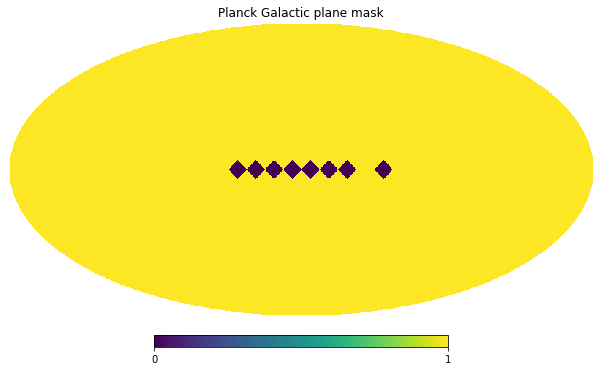

In [26]:
# show downgraded mask
hp.mollview(mask, title='Planck Galactic plane mask')

In [7]:
# print some relevant info 
fsky = np.mean(mask)
npix = np.int(sum(mask))
print("fsky=%.2g %% (npix=%d)" % (100*fsky,npix))
toGB = 1024. * 1024. * 1024.
emem = 8.*(npix*2*npix*2) * ( len(lth)*2 ) / toGB
print("mem=%.2g Gb" % emem)

fsky=45 % (npix=344)
mem=0.16 Gb


In [8]:
# define parameters used later
stokes, spec, istokes, ispecs = getstokes( spec=spec)
print(stokes, spec, istokes, ispecs)
nspec = len(spec)
nstoke = len(stokes)

['Q', 'U'] ['EE', 'BB'] [1, 2] [1, 2]


In [9]:
############# Generate pixel-pixel Covariance matrix ##############
npixtot = len(mask)
mask = np.asarray(mask,bool)
ipok = np.arange(npixtot)[mask] # pixel indexes outside the mask
Slmax = lmax
fpixw = extrapolpixwin(nside, lmax, pixwin=pixwin)
bl = hp.gauss_beam(deg2rad(fwhm), lmax=lmax, pol=True) # beam starts from ell=0
bl = bl[:,2] # choose polarization beam
norm = bl[0: Slmax + 1]**2 * fpixw[0: Slmax + 1]**2

In [10]:
# ############## Generate White Noise ###############
pixvar = Karcmin2var(muKarcmin, nside)
varmap = ones((nstoke * npix)) * pixvar
NoiseVar = np.diag(varmap)

In [11]:
# define binning
bins = xqml.Bins.fromdeltal(lmin, lmax, dell)
lb = bins.lbin

In [12]:
## ############## Initialise xqml estimator class ###############
esti = xqml.xQML(mask, bins, clth, NA=NoiseVar, NB=NoiseVar, lmax=lmax,
                 fwhm=fwhm, spec=spec, pixwin=pixwin)

xQML
spec:  ['EE', 'BB']
nbin:  22
Memset: 0.16 Gb (2,22,2,344)
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [#########

In [13]:
############## Construct MC ###############
allcl = []
t = []
nsimu_corr = nsimu
for n in range(nsimu_corr):
    progress_bar(n, nsimu_corr)
    seed = n # seed must be the same used in pseudo-cls simulations for consistency
    np.random.seed(seed)
    # generate Gaussian realizations from the fiducial theory spectrum
    cmb = np.array(hp.synfast(clth[:, :len(fpixw)]*(fpixw*bl)**2,
                                   nside,
                                   pixwin=False,
                                   lmax=lmax,
                                   fwhm=0.0,
                                   new=True,
                                   verbose=False))
    # mask map realization                               
    cmbm = cmb[istokes][:, mask]
    # create white noise map
    noise_map = np.random.randn(nstoke, npix) * sqrt(pixvar)
    # sum CMB signal and noise maps
    dmA = cmbm + noise_map
    s1 = timeit.default_timer()
    # call xqml estimator class
    allcl.append(esti.get_spectra(dmA, dmA)) # I use the cross-estimator but the two maps are the same so the output is an auto-spectrum 
    t.append( timeit.default_timer() - s1) # time the estimator 

 [####################] 100% Done...


In [14]:
print( "get_spectra: %f sec" % mean(t))

get_spectra: 0.005786 sec


In [15]:
hcl = mean(allcl, 0) # mean of the spectra at each ell
scl = std(allcl, 0) # standard deviation at each ell

In [16]:
# save simulations spectra
np.save('allcl_whitenoise_fsky'+str(fsky)+'_thresh_'+str(thresh)+'_field_'+str(planck_field)+'.npy', allcl)

In [17]:
def Nell(depth_p, fwhm, lmax):  
    '''
    White noise spectrum expectation.
    beam fwhm in degrees.
    '''
    bl = hp.gauss_beam(np.radians(fwhm), lmax=lmax+1, pol=True)[:,2] 
    nl = (np.radians(depth_p/60.) / np.array(bl))**2 
    return nl[2:]

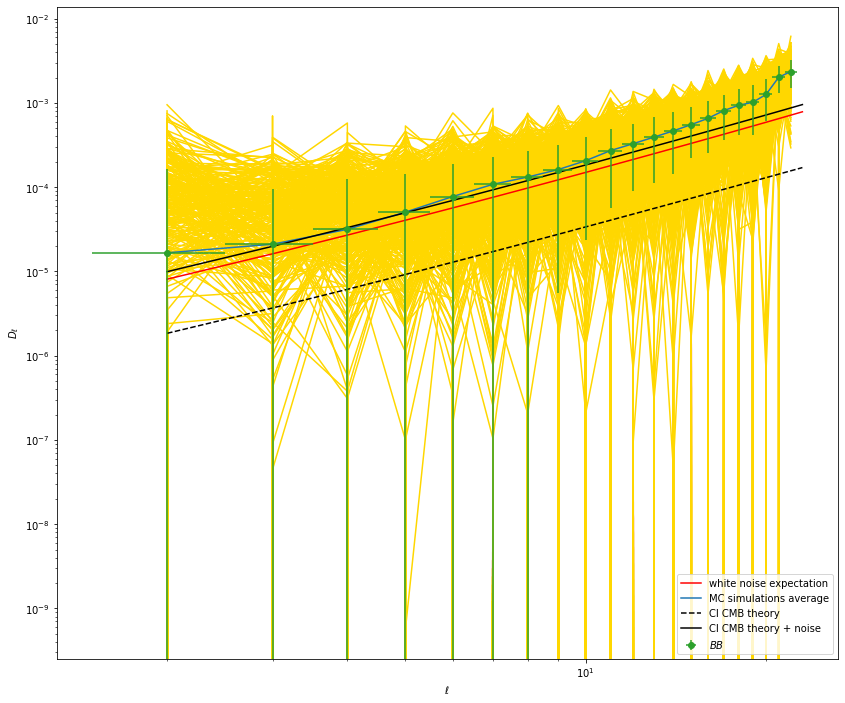

In [19]:
# ############## Plot estimator results ###############
ell = np.arange(2, lmax+1)
lb = lb[:-1]

# plot BB
fig = plt.figure(figsize=(14,12), facecolor='w', edgecolor='k')
ax = plt.gca()
toDl = lb*(lb+1)/2./np.pi

s=1 # take only BB spectra
for i in range(nsimu_corr):
    plot(lb, toDl*allcl[i][s], color='gold')
    
errorbar(lb, toDl*hcl[s], yerr=toDl*scl[s], xerr=(bins.dl/2)[:-1], fmt='o',
         color='C%i' % ispecs[s], label=r"$%s$" % spec[s], zorder=1000)
plot(ell, ell*(ell+1)/2./np.pi*Nell(muKarcmin, fwhm, lmax)[:-1], color='red', label='white noise expectation')
loglog()
plot(lb, toDl*hcl[s], label='MC simulations average')
plot(lth, lth*(lth+1)/2./np.pi*clth[2][2:max(lth)+1].T, '--k', label='Cl CMB theory')
plot(lth, lth*(lth+1)/2./np.pi*(clth[2][2:max(lth)+1].T+Nell(muKarcmin, fwhm, lmax)[:-1]), '-', color='black', label='Cl CMB theory + noise')


ylabel(r"$D_\ell$")
xlabel(r"$\ell$")
legend(loc=4, frameon=True)
savefig('xQML_BB_Planck_whitenoise_fsky'+str(fsky)+'.pdf', format='pdf', dpi=1000, bbox_inches='tight')
show()


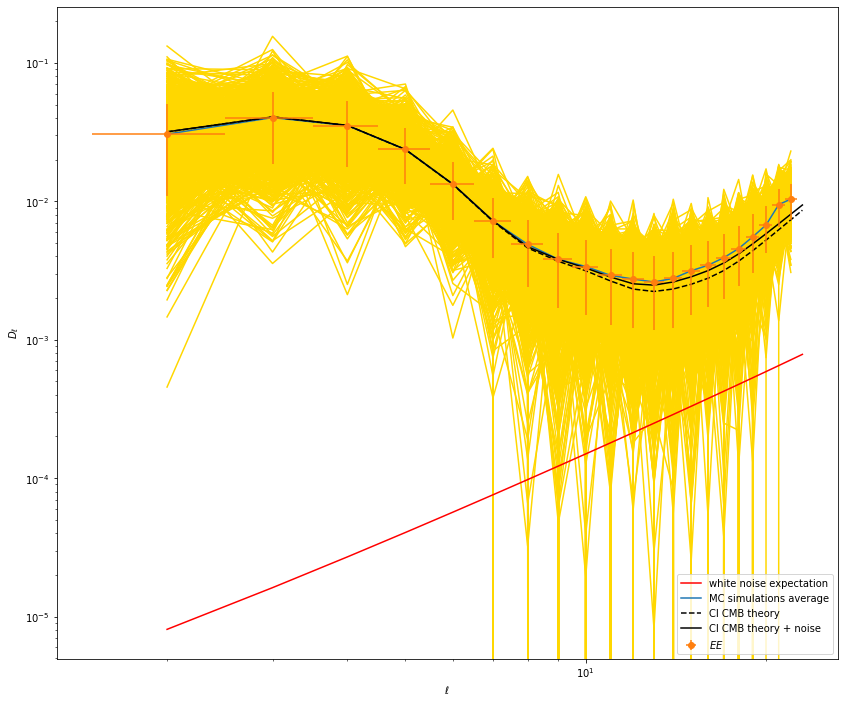

In [20]:
# plot EE
fig = plt.figure(figsize=(14,12), facecolor='w', edgecolor='k')
ax = plt.gca()

s=0 # take only EE spectra
for i in range(nsimu_corr):
    plot(lb, toDl*allcl[i][s], color='gold')
    
errorbar(lb, toDl*hcl[s], yerr=toDl*scl[s], xerr=(bins.dl/2)[:-1], fmt='o',
         color='C%i' % ispecs[s], label=r"$%s$" % spec[s], zorder=1000)
plot(ell, ell*(ell+1)/2./np.pi * Nell(muKarcmin, fwhm, lmax)[:-1], color='red', label='white noise expectation')
loglog()
plot(lb, toDl*hcl[s], label='MC simulations average')
plot(lth, lth*(lth+1)/2./np.pi*clth[1][2:max(lth)+1].T, '--k', label='Cl CMB theory')
plot(lth, lth*(lth+1)/2./np.pi*(clth[1][2:max(lth)+1].T+Nell(muKarcmin, fwhm, lmax)[:-1]), '-', color='black', label='Cl CMB theory + noise')


ylabel(r"$D_\ell$")
xlabel(r"$\ell$")
legend(loc=4, frameon=True)
savefig('xQML_EE_Planck_whitenoise_fsky'+str(fsky)+'.pdf', format='pdf', dpi=1000, bbox_inches='tight')
show()
